### <h2 style="font-size: 40px;">Состояние пациента по отзыву на лекарство</h2>

#### Техническое задание

Разработать модель машинного обучения, которая по тексту отзыва пациента на лекарство предсказывает его состояние. \
Если оценка лекарства пользователем менее 7, то лекарство не помогло и состояние пациента не улучшилось.

#### Описание данных

- `uniqueID` - уникальный идентификатор пользователя
- `drugName` - 	название лекарственного средства
- `condition` - место применения
- `review` - отзыв пользователя на лекарство
- `rating` - оценка лекарства пользователем
- `date` - дата публикации отзыва
- `usefulCount` - количество пользователей, которые сочли отзыв корректным

### Загрузка данных

In [27]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import logging


from tqdm import tqdm
from transformers import pipeline

RANDOM_STATE=42
np.random.seed(RANDOM_STATE)
logging.getLogger("transformers").setLevel(logging.ERROR)
tqdm.pandas()

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [29]:
# Загрузка и распаковка датасетов

#!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
#!unzip drugsCom_raw.zip -d ./datasets/
#!rm drugsCom_raw.zip

In [30]:
# Функция для быстрого ознакомления и парсинга таблицы
def parse_dataset(path):
    df = pd.read_csv(path, sep='\t', parse_dates=['date'])
    display(df.head())

    display(round(df.isna().mean() * 100, 2).sort_values(ascending=False).to_frame(name='Процент пропусков'))

    df.info()
    return df


# Функция для проверки наличия файла
def check_dataset(path):    
    if os.path.exists(path):
        return parse_dataset(path)
    else:
        print('Неправильный путь к файлу')

In [31]:
drugs_data = check_dataset('./datasets/drugsComTrain_raw.tsv')

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


,Процент пропусков
condition,0.56
Unnamed: 0,0.00
drugName,0.00
review,0.00
rating,0.00
date,0.00
usefulCount,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   161297 non-null  int64         
 1   drugName     161297 non-null  object        
 2   condition    160398 non-null  object        
 3   review       161297 non-null  object        
 4   rating       161297 non-null  float64       
 5   date         161297 non-null  datetime64[ns]
 6   usefulCount  161297 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 8.6+ MB


При загрузки датасета признак `uniqueID` был загружен как `	Unnamed: 0`, дата была переведена в формат datetime64. В датасете наблюдается 0.56% пропусков в столбце с местом применения `condition`. 

In [32]:
drugs_data_test = check_dataset('./datasets/drugsComTest_raw.tsv')

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,2009-05-17,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,2017-03-05,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4


,Процент пропусков
condition,0.55
Unnamed: 0,0.00
drugName,0.00
review,0.00
rating,0.00
date,0.00
usefulCount,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   53766 non-null  int64         
 1   drugName     53766 non-null  object        
 2   condition    53471 non-null  object        
 3   review       53766 non-null  object        
 4   rating       53766 non-null  float64       
 5   date         53766 non-null  datetime64[ns]
 6   usefulCount  53766 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 2.9+ MB


В отзывах на лекарства наблюдается спец-символ *\&#039;*, который является апострофом ('). В датасете наблюдается 0.55% пропусков в столбце с местом применения `condition`. 

### Предобработка данных

In [33]:
drugs_data.rename({'Unnamed: 0':'id'}, axis=1, inplace=True)
drugs_data_test.rename({'Unnamed: 0':'id'}, axis=1, inplace=True)

Название колонки уникального идентификатора пользователя было переименовано в `id`.

In [34]:
drugs_data.duplicated(subset=["id"]).sum()

np.int64(0)

В тренировочном датасете отсутствуют неявные дубликаты.

In [35]:
drugs_data.dropna(axis=0, inplace=True)

Наблюдения с пропусками в признаке `condition` были удалены.

In [36]:
lst_idx = np.random.randint(0, len(drugs_data), 5)

for i in (lst_idx):
    print(drugs_data['review'][i])
    print()

"When I went to the doctor and told him Linzess 290 mg wasn&#039;t working for me ( I was lucky to go once a week).,He said I want to try you on Amitiza. He said this should help. Well I have been on it for 3 days and nothing!! I got a headache &amp; chest pain the first day and only headaches on the second and third day. I can&#039;t understand why the doctors can&#039;t find out the underlying problem. I have tried everything!! I use to take Zelnorm but, they took that off the market. I don&#039;t care for this drug! My stomach makes noises and that&#039;s it!! I am still miserable!!"

"Very interesting drug. I was prescribed Zolpidem by my psychiatrist but found that it did not work (later determined because of other psychological problems) however I still took it every night. I found that I started doing things I would never do normally. I went for walks at 3:00 am, fully cognitive, came home put my shoes away, hung up my clothes, and watched TV for a few hours. I felt perfectly no

В отзывах наблюдается специальный символ *\&#039;*. Также имеются повторяющиеся пробелы.

In [37]:
# Функция для очистки отзывов пользователей
def get_clean_text(row_review):
    row_review = row_review.replace('&#039;', "'")
    row_review = re.sub(r'[(),.!?@\\;"]', '', row_review)
    row_review = re.sub(r'[/-]', ' ', row_review)
    row_review = re.sub(r'\s+', ' ', row_review)
    return row_review.lower()

In [38]:
drugs_data['review'] = drugs_data['review'].apply(get_clean_text)
drugs_data_test['review'] = drugs_data_test['review'].apply(get_clean_text)

Отзывы тренировочного и тестового датасетов были предобработаны. Специальный символ изменен на апостроф. Скобки, знаки препинания и повторяющиеся пробелы были удалены.

In [39]:
for i in (lst_idx):
    print(drugs_data['review'][i])
    print()

when i went to the doctor and told him linzess 290 mg wasn't working for me i was lucky to go once a weekhe said i want to try you on amitiza he said this should help well i have been on it for 3 days and nothing i got a headache &amp chest pain the first day and only headaches on the second and third day i can't understand why the doctors can't find out the underlying problem i have tried everything i use to take zelnorm but they took that off the market i don't care for this drug my stomach makes noises and that's it i am still miserable

very interesting drug i was prescribed zolpidem by my psychiatrist but found that it did not work later determined because of other psychological problems however i still took it every night i found that i started doing things i would never do normally i went for walks at 3:00 am fully cognitive came home put my shoes away hung up my clothes and watched tv for a few hours i felt perfectly normal but my wife started questioning me about what i was sa

### Исследовательский анализ

In [40]:
drugs_data.iloc[:, 1:].describe()

,rating,date,usefulCount
count,160398.000000,160398,160398.000000
mean,6.995923,2014-06-15 18:14:26.973403904,28.097613
min,1.000000,2008-02-24 00:00:00,0.000000
25%,5.000000,2012-04-21 00:00:00,6.000000
50%,8.000000,2015-06-13 00:00:00,16.000000
75%,10.000000,2016-08-20 00:00:00,36.000000
max,10.000000,2017-12-12 00:00:00,1291.000000
std,3.272303,NaN,36.457876


Данные были собраны в период с 2008 по 2017 год. Большинство отзывов пользователей содержат от 6 до 36 корректных оценок. 

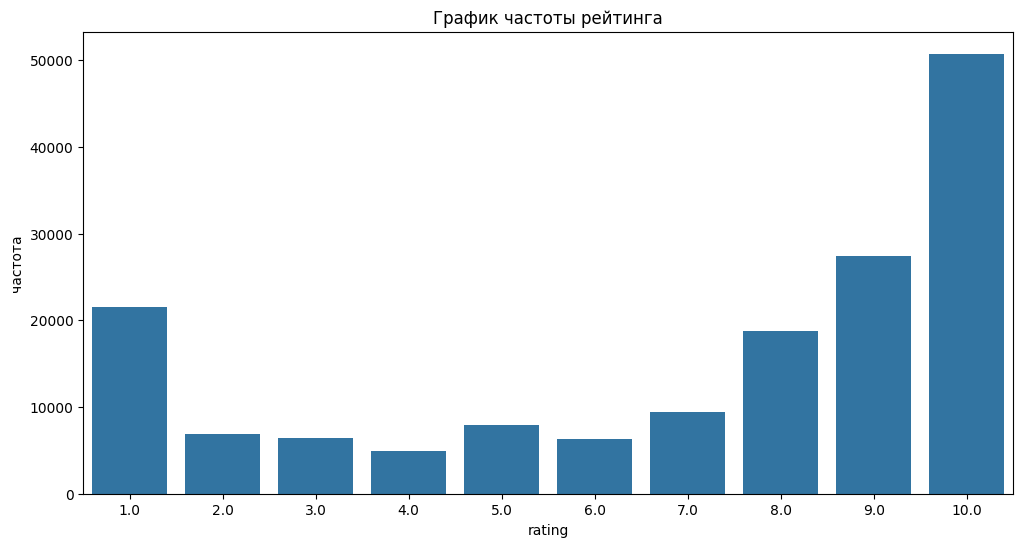

In [41]:
plt.figure(figsize=(12, 6))
plt.title('График частоты рейтинга')

sns.countplot(data=drugs_data, x='rating')
plt.ylabel('частота')
plt.show()

Медианное значение рейтинга составляет 8 баллов, что указывает на преобладание положительных оценок — отзывы с рейтингами, близкими к 10, встречаются чаще всего. Среди рейтингов менее 5 баллов, чаще всего встречается 1 балл.

In [42]:
# Функция для оценки распределения слов в отзовах
def get_stats_hist(df, clm):
    plt.figure(figsize=(12, 6))

    len_token = df[clm].apply(lambda x: len(x.split()))
    plt.title('Распределение количества слов, содержащихся в отзовах')
    sns.kdeplot(data=len_token, bw_method=0.1)

    plt.ylabel('частота')
    plt.xlabel('количество слов в отзове')
    plt.show()

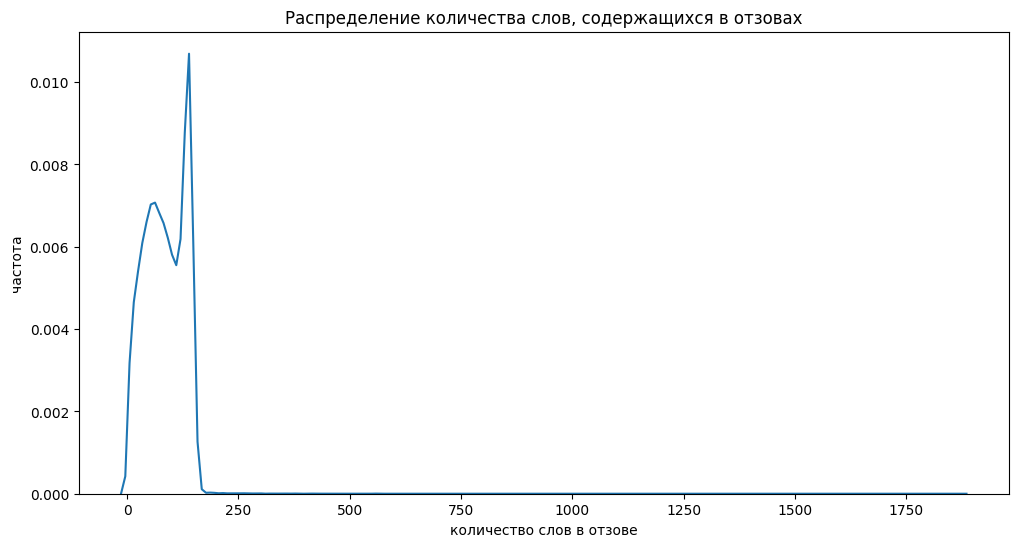

In [43]:
get_stats_hist(drugs_data, 'review')

Чаще всего отзывы содержат до 250 слов. Бывают очень большие отзывы, стоит применить суммаризацию для усечения текста и сохранения контекста.

In [45]:
summarizer = pipeline("summarization", model="allenai/led-base-16384")

In [46]:
def set_summarization_text(data, clm):
    df = data[data[clm].apply(lambda x: len(x.split())) > 180].copy()

    summaries = []
    for text in tqdm(df[clm], desc="Уменьшение длины текста"):
        summary = summarizer(text, max_length=100, min_length=5)[0]['summary_text']
        summaries.append(summary)

    data.loc[df.index, clm] = summaries

In [48]:
set_summarization_text(drugs_data, 'review')

Уменьшение длины текста: 100%|██████████| 341/341 [01:42<00:00,  3.32it/s]


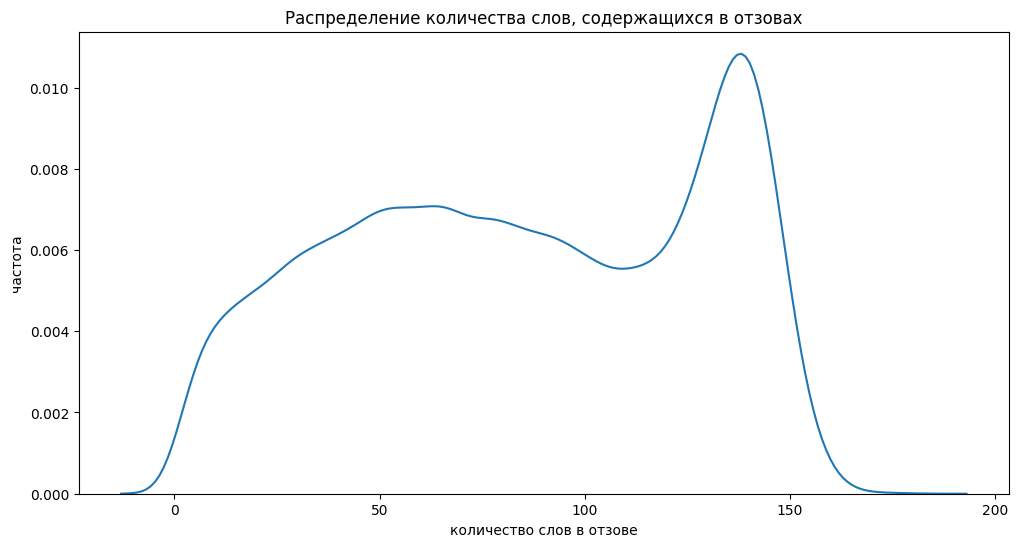

In [49]:
get_stats_hist(drugs_data, 'review')